In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import fully_connected, l2_regularizer
from tensorflow.contrib.framework import arg_scope
from sklearn.preprocessing import MinMaxScaler
from util import *

%matplotlib inline

### Load the dataset

In [2]:
X_train_orig, Y_train, X_cval_orig, Y_cval = load_dataset('datasets/dog_vs_cat_dataset_kaggle_128px.h5')

print('Train X shape', X_train_orig.shape)
print('Train Y shape', Y_train.shape)
print('CVal X shape', X_cval_orig.shape)
print('CVal Y shape', Y_cval.shape)

Train X shape (22500, 128, 128, 3)
Train Y shape (22500, 1)
CVal X shape (2500, 128, 128, 3)
CVal Y shape (2500, 1)


### Check out some of the data and it's label

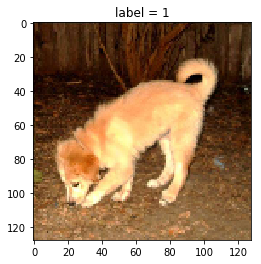

In [6]:
index = 8

x_check = X_train_orig[index]
#x_check = x_check / 255

plt.imshow(x_check)
plt.title('label = ' + str(np.squeeze(Y_train[index])))

### Pre-process the data

**Normalize** - Normalize the data by dividing the matrix by 255. This should scale all the pixel values between 0 and 1.

**Reshape the data** - Reshape the image data from shape (n_samples, n_px \* n_px \* 3), where 3 stands for RGB channels to the shape (n_samples, n_px \* n_px \* 3). We are rolling up the image into a feature vector of size n_px \* n_px \* 3.

X shape after reshaping would be (n_samples, n_px \* n_px \* 3)

In [4]:
#Normalize the data set
X_train = normalize_data(X_train_orig, 2500)
X_cval = normalize_data(X_cval_orig, 2500)

#X_train = X_train[0:5000, :]
#X_cval = X_cval[0:5000, :]
#Y_train = Y_train[0:5000, :]
#Y_cval = Y_cval[0:5000, :]

#Reshape the data set
X_train = X_train.reshape(X_train.shape[0], -1)
X_cval = X_cval.reshape(X_cval.shape[0], -1)

print('X train shape after reshaping =', X_train.shape)
print('X cval shape after reshaping = ', X_cval.shape)

2500 images normalized
5000 images normalized
7500 images normalized
10000 images normalized
12500 images normalized
15000 images normalized
17500 images normalized
20000 images normalized
22500 images normalized
2500 images normalized
X train shape after reshaping = (22500, 49152)
X cval shape after reshaping =  (2500, 49152)


### Build the DNN using plain TensorFlow

**Step 1 - Code the individual ops in the computation graph**
- Create Placeholders for X, Y
- Create the nn_model - all the layers and initialize them
- Compute the cost
- Create the optimizer to minimize the cost
- Evaluate the model

**Step 2 - Build the computation graph**
- Combine all the steps in Step 1 to build the computation graph
- Initialize the variables
- Create a Saver object to save the learnt parameters after the model is trained

**Step 3 - Execute the graph**
- Create mini batches so that gradient descent works on these mini batches for every step instead of all instances
- Train the model for a given number of epochs
- Print the cost, train accuracy & test accuracy at regular interval of epochs
- Plot the training error (cost) vs epochs
- Save the parameters

**Step 4 - Predict for any data**
- Build a method to pass random data for the model to predict based on the parameters learnt through training

### Create the placeholders

In [5]:
def create_placeholders(n_inputs):
    '''
    n_inputs - A scalar containing the number of input features
    '''
    
    X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = 'X')
    Y = tf.placeholder(tf.float32, shape = (None, 1), name = 'Y')
    
    return X, Y

### Create the NN model

In [6]:
def nn_model(X, n_neurons):
    '''
    X - input Tensor X
    n_neurons - A scalar containing the number of neurons in each layer including both hidden layers and output layer 
    '''
    #with arg_scope([fully_connected], weights_regularizer = l2_regularizer(scale = 0.01)):
    hidden_layer_1 = fully_connected(X, n_neurons['hidden_layer_1'], scope = 'hidden_layer_1')
    hidden_layer_2 = fully_connected(hidden_layer_1, n_neurons['hidden_layer_2'], scope = 'hidden_layer_2')
    hidden_layer_3 = fully_connected(hidden_layer_2, n_neurons['hidden_layer_3'], scope = 'hidden_layer_3')
    hidden_layer_4 = fully_connected(hidden_layer_3, n_neurons['hidden_layer_4'], scope = 'hidden_layer_4')
    hidden_layer_5 = fully_connected(hidden_layer_4, n_neurons['hidden_layer_5'], scope = 'hidden_layer_5')
    logits = fully_connected(hidden_layer_3, n_neurons['output_layer'], activation_fn = None, scope = 'output_layer')
    
    return logits

### Compute the cost

In [7]:
def compute_cost(labels, logits):
    '''
    labels - label tensor Y
    logits - Tensor containing the values of the output layer before passing to the activation function
    '''
    
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
    cost = tf.reduce_mean(cross_entropy, name = 'cost')
    #base_cost = tf.reduce_mean(cross_entropy)
    #reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #cost = tf.add_n([base_cost] + reg_losses, name = 'cost')
    
    return cost

### Create the optimizer and the training operation

In [8]:
def optimizer(learning_rate, cost):
    '''
    learning_rate - A scalar value containing the learning rate for the backpropagation step
    cost - Overall cost from the forward propagation step for one set of mini batch instance
    '''
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(cost)
    
    return training_op

### Evaluate the model

We will use accuracy as the evaluation metric

In [9]:
def evaluate_model(logits, Y):
    '''
    logits - An array containing the values from the output layer
    Y - An array containing the labels
    '''
    
    #Compute the probability using the sigmoid function
    y_pred = tf.nn.sigmoid(logits)
    #Convert it to 0 or 1 class based on the probability and cast it to integer
    y_pred = tf.cast(y_pred > 0.5, tf.int64)
    #y_pred = tf.cast(tf.round(y_pred), tf.int64)
    
    #Create a boolean tensor by comparing the model prediction against the labels
    correct_prediction = tf.equal(y_pred, tf.cast(Y, tf.int64))
    #Compute the accuracy across all the instances
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return accuracy

### Build the computation graph & execute it

In [10]:
def train_model(X_train, Y_train, X_cval, Y_cval, n_neurons, 
               learning_rate = 0.01, mini_batch_size = 64, n_epochs = 50, print_cost = False):
    
    tf.reset_default_graph()
    
    #Declare and initialize the required variables
    (n_samples, n_inputs) = X_train.shape
    costs = []
    
    #Create Placeholder
    X, Y = create_placeholders(n_inputs)
    
    #Create the nn_model
    logits = nn_model(X, n_neurons) 
    
    #Compute the cost
    cost = compute_cost(Y, logits)
    
    #Optimize the cost using Gradient Descent Optimizer
    training_op = optimizer(learning_rate, cost)
    
    #Evaluate the model
    accuracy = evaluate_model(logits, Y)
    
    #Initialize the variables
    init = tf.global_variables_initializer()
    
    #Create the Saver object
    saver = tf.train.Saver()
    
    #Execute the Graph - Train the model
    with tf.Session() as sess:
        init.run()
        
        n_mini_batches = int(n_samples / mini_batch_size)
        
        for epoch in range(1, n_epochs + 1):
            epoch_cost = 0
            mini_batches = create_random_mini_batches(X_train, Y_train, mini_batch_size = mini_batch_size, 
                                                      one_hot_vector_flag = False)
            
            for mini_batch in mini_batches:
                (X_mini_batch, Y_mini_batch) = mini_batch
                _, mini_batch_cost = sess.run([training_op, cost], feed_dict = {X: X_mini_batch, Y: Y_mini_batch})
                
                epoch_cost += mini_batch_cost
            
            epoch_cost = epoch_cost / n_mini_batches
            train_accuracy = accuracy.eval(feed_dict = {X: X_train, Y: Y_train})
            cval_accuracy = accuracy.eval(feed_dict = {X: X_cval, Y: Y_cval})
            
            if print_cost and epoch % 20 == 0:
                print('At epoch', epoch, 'Cost =', epoch_cost, '| Train Accuracy =', train_accuracy, 
                      '| CVal Accuracy =', cval_accuracy)
            
            if epoch % 10 == 0:
                costs.append(epoch_cost)
            
        saver_path = saver.save(sess, './my_model_final.ckpt')
        
    print('Final - Train Accuracy =', train_accuracy, '| CVal Accuracy =', cval_accuracy)
        
    plt.plot(costs)
    plt.xlabel('# of Epochs (in tens)')
    plt.ylabel('Training Error - Cost')
    plt.title('Training Error Vs Epochs')
    plt.show()
    
    return saver_path

In [11]:
n_neurons = {'hidden_layer_1': 50,
             'hidden_layer_2': 50,
             'hidden_layer_3': 50,
             'hidden_layer_4': 50,
             'hidden_layer_5': 30,
             'output_layer': 1}
train_model(X_train, Y_train, X_cval, Y_cval, n_neurons, learning_rate = 0.01, n_epochs = 200, mini_batch_size = 64,
            print_cost = True)

At epoch 20 Cost = 0.695145832677 | Train Accuracy = 0.500267 | CVal Accuracy = 0.498
At epoch 40 Cost = 0.69525329221 | Train Accuracy = 0.500267 | CVal Accuracy = 0.498
At epoch 60 Cost = 0.695372550406 | Train Accuracy = 0.500267 | CVal Accuracy = 0.498


KeyboardInterrupt: 